## VAE 코드 구현 연습

In [21]:
import torch

seed = 2023

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(seed=seed)
torch.set_float32_matmul_precision("high")

if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed=seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [22]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dataset = datasets.FashionMNIST(
    root='.fashion_mnist',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = datasets.FashionMNIST(
    root='.fashion_mnist',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

torch.Size([64, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([3, 242, 242])


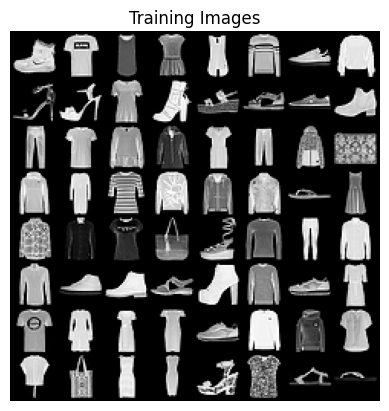

In [23]:
from torchvision import utils # 시각화를 위한 라이브러리
import matplotlib # 시각화를 위한 라이브러리
from matplotlib import pyplot as plt # 시각화를 위한 라이브러리
import numpy as np #numpy 데이터 형식을 다루기 위한 라이브러리

plt.axis('off')
plt.title("Training Images")

image = train_dataset.data[:64]
print(image.shape)
print(image.unsqueeze(1).shape)
grid = utils.make_grid(image.unsqueeze(1))
print(grid.shape)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [24]:
from torch import nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()
        
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_mean = nn.Linear(128, latent_dim)

    def forward(self, x: torch.Tensor):
        x = x.view(x.size(0), -1) # (배치사이즈, 채널, 가로, 세로) => (배치사이즈, 채널 x 가로 x 세로)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        z = F.leaky_relu(self.fc_mean(x))
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()

        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 28 * 28)

    def forward(self, z: torch.Tensor):
        z = F.leaky_relu(self.fc1(z), negative_slope=0.2)
        z = F.leaky_relu(self.fc2(z), negative_slope=0.2)
        x_hat = torch.sigmoid(self.fc3(z))
        x_hat = x_hat.view(z.size(0), 1, 28, 28)
        return x_hat

In [25]:
class Autoencoder(nn.Module):
    def __init__(self, encoder=Encoder, decoder=Decoder, latent_dim: int=20):
        super().__init__()
        self.encoder = encoder(latent_dim=latent_dim)
        self.decoder = decoder(latent_dim=latent_dim)

        self.latent_dim = latent_dim

    def forward(self, x: torch.Tensor):
        z = self.encode(x)
        x_hat = self.decode(z)
        return z, x_hat

    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def decode(self, z: torch.Tensor):
        return self.decoder(z)

In [26]:
class VariationalEncoder(Encoder):
    def __init__(self, latent_dim: int=20):
        super().__init__(latent_dim=latent_dim)

        self.fc_log_var = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)

        mean = self.fc_mean(x)
        # 오토 인코더와의 주요 차이점
        log_var = self.fc_log_var(x)

        return mean, log_var

In [27]:
class VariationalAutoencoder(Autoencoder):
    def __init__(self, encoder=VariationalEncoder, decoder=Decoder, latent_dim: int=16):
        super().__init__(latent_dim=latent_dim)
        self.encoder = encoder(latent_dim)

    def reparameterize(self, mean: torch.Tensor, log_var: torch.Tensor):
        # 샘플링 시에도 기울기를 전달할 수 있도록 재매개변수화 합니다.
        std = torch.exp(0.5 * log_var)
        # randn_like 메소드는 입력된 인자와 같은 차원의 값들을
        # 표준 정규 분포에서 샘플링하여 반환합니다.
        epsilon = torch.randn_like(std)

        return mean + (epsilon * std)

    def forward(self, x: torch.Tensor):
        # 인코더를 통해 얻어지는 값이 오토 인코더와 다릅니다.
        mean, log_var = self.encode(x)
        # 재매개변수화를 진행합니다.
        z = self.reparameterize(mean, log_var)
        # 오토 인코더와 같습니다.
        x_hat = self.decode(z)

        return x_hat, mean, log_var

In [28]:
import numpy as np

latent_mean = 10
std = 5
N = 1000

In [29]:
dist_origin = np.random.normal(latent_mean, std, N)
print(f"정규 분포에서 샘플링한 데이터의 평균은 {dist_origin.mean()} 입니다.")
print(f"정규 분포에서 샘플링한 데이터의 표준 편차는 {dist_origin.std()} 입니다.")

정규 분포에서 샘플링한 데이터의 평균은 9.903788871904121 입니다.
정규 분포에서 샘플링한 데이터의 표준 편차는 5.1103114788190025 입니다.


In [30]:
dist_reparam = latent_mean + std*np.random.normal(0, 1, N)
print(f"재매개변수화를 적용한 데이터의 평균은 {dist_reparam.mean()} 입니다.")
print(f"재매개변수화를 적용한 데이터의 표준 편차는 {dist_reparam.std()} 입니다.")

재매개변수화를 적용한 데이터의 평균은 9.933746972286219 입니다.
재매개변수화를 적용한 데이터의 표준 편차는 4.962720578072453 입니다.


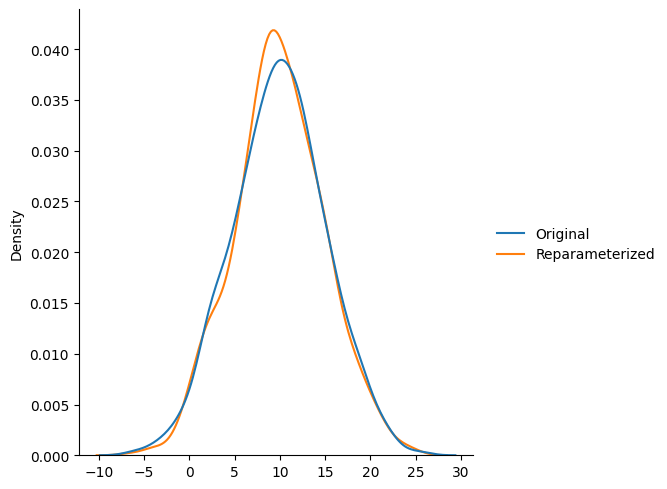

In [31]:
import seaborn as sns

sns.displot(
    {"Original": dist_origin, "Reparameterized": dist_reparam},
    kind="kde",
)


In [32]:
"""
쿨백-라이블러 발산(Kullback-Leibler divergence, KL divergence)은 두 확률분포 간의 차이를 측정하는 데 사용되는 척도입니다.
특히, 한 확률분포가 다른 확률분포와 얼마나 다른지를 정량화합니다. KL divergence는 항상 0 이상이며, 두 분포가 동일할 때 0이 됩니다.
KL divergence는 대칭적이지 않으므로, P와 Q의 KL divergence는 Q와 P의 KL divergence와 일반적으로 다릅니다.

수학적으로 KL divergence는 다음과 같이 정의됩니다.

D_KL(P||Q) = Σ P(x) log(P(x) / Q(x))

여기서 P(x)는 실제 분포, Q(x)는 근사 분포를 나타냅니다. KL divergence는 P(x)와 Q(x)가 얼마나 다른지를 측정하며,
Q(x)를 사용하여 P(x)를 근사할 때 정보 손실의 양을 나타냅니다.

VAE(Variational Autoencoder)에서는 KL divergence를 사용하여 잠재 공간의 분포가 사전 정의된 분포(일반적으로 표준 정규 분포)와
가깝도록 규제하는 데 사용됩니다. 이는 잠재 공간이 연속적이고 잘 구조화되도록 하여, 새로운 데이터를 생성할 때 의미 있는 결과를 얻을 수 있도록 합니다.
"""
def KLDivergenceLoss(mean, log_var):
    return torch.sum(-0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()))

In [33]:
# 평균 0, 표준편차 1인 정규 분포에서 1000개의 샘플을 추출합니다.
dist_origin = np.random.normal(0, 1, 1000)

KL-Divergence 값은 1.3068528175354004 입니다.


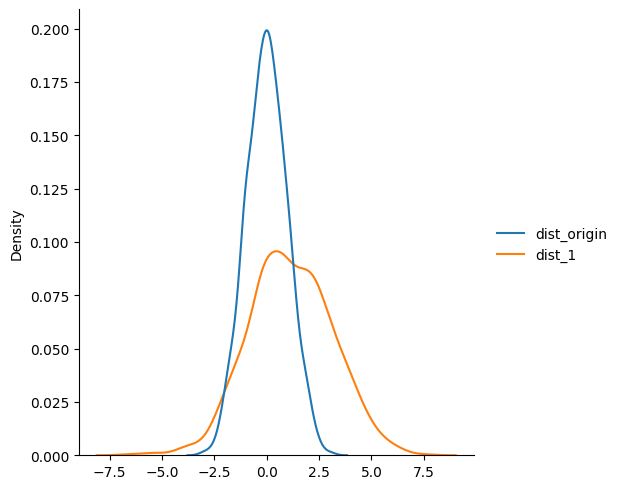

In [34]:
"""
평균과 표준편차를 변경해가며 KL Divergence 값을 확인해봅니다.
"""
latent_mean, sigma = 1, 2
dist_1 = np.random.normal(latent_mean, sigma, 1000)

sns.displot(
    dict(
        dist_origin=dist_origin,
        dist_1=dist_1,
    ), multiple="layer", kind="kde"
)

kld = KLDivergenceLoss(torch.Tensor([latent_mean]), torch.Tensor([np.log(np.square(sigma))]))
print(f"KL-Divergence 값은 {kld} 입니다.")

KL-Divergence 값은 3.8075852394104004 입니다.


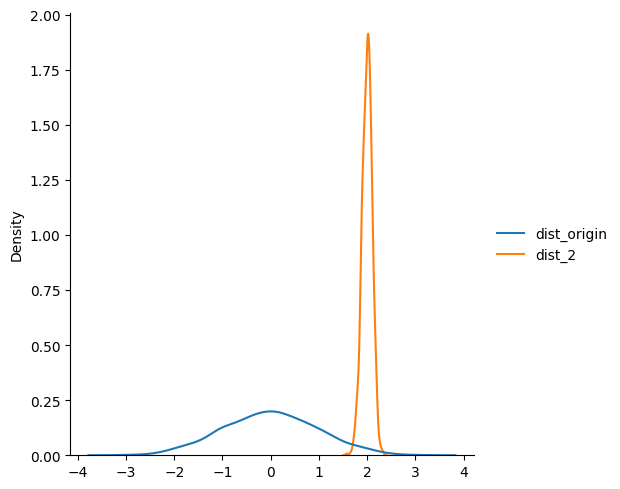

In [35]:
"""
평균이 2, 표준편차가 0.1인 정규 분포를 생성하고,
기존의 dist_origin 분포와 함께 시각화하여 비교합니다.
KL Divergence 값을 계산하여 두 분포의 차이를 정량적으로 확인합니다.
"""
latent_mean, sigma = 2, 0.1
dist_2 = np.random.normal(latent_mean, sigma, 1000)

sns.displot(
    dict(
        dist_origin=dist_origin,
        dist_2=dist_2,
    ), multiple="layer", kind="kde"
)

kld = KLDivergenceLoss(torch.Tensor([latent_mean]), torch.Tensor([np.log(np.square(sigma))]))
print(f"KL-Divergence 값은 {kld} 입니다.")

KL-Divergence 값은 0.0 입니다.


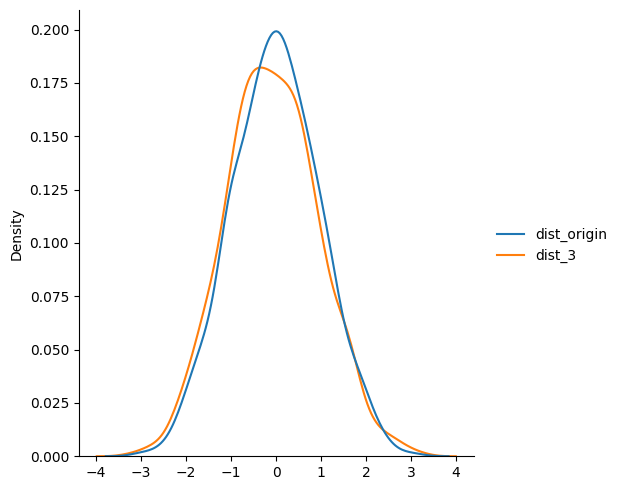

In [36]:
"""
평균이 0, 표준편차가 1인 정규 분포를 생성하고,
기존의 dist_origin 분포와 함께 시각화하여 비교합니다.
KL Divergence 값을 계산하여 두 분포의 차이를 정량적으로 확인합니다.
"""
latent_mean, sigma = 0, 1
dist_3 = np.random.normal(latent_mean, sigma, 1000)

sns.displot(
    dict(
        dist_origin=dist_origin,
        dist_3=dist_3,
    ), multiple="layer", kind="kde"
)

kld = KLDivergenceLoss(torch.Tensor([latent_mean]), torch.Tensor([np.log(np.square(sigma))]))
print(f"KL-Divergence 값은 {kld} 입니다.")

In [37]:
def binary_cross_entropy(x, recon):
    """
    이진 교차 엔트로피 손실을 계산합니다.

    Args:
        x (torch.Tensor): 원본 입력 데이터.
        recon (torch.Tensor): 재구성된 데이터.

    Returns:
        torch.Tensor: 이진 교차 엔트로피 손실 값.
    """
    return -torch.sum(x * torch.log(recon) + (1 - x) * torch.log(1 - recon))

In [38]:
# 학습률(learning rate) 설정
learning_rate = 0.001

# 배치 크기(batch size) 설정
batch_size = 100

# 학습 에폭(epochs) 설정
epochs = 30

# 잠재 공간(latent space)의 차원 설정
latent_dim = 20

# 학습 데이터 로더(data loader) 설정: train_dataset을 batch_size 단위로 묶고, 매 에폭마다 섞음
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True)

# 테스트 데이터 로더(data loader) 설정: test_dataset을 batch_size 단위로 묶음 (평가는 섞을 필요 없음)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False)

In [39]:
from torch import optim

# Variational Autoencoder 모델 초기화 및 device 설정
vae = VariationalAutoencoder(latent_dim=latent_dim).to(device)

# Reconstruction Loss 함수 설정 (Binary Cross Entropy)
recon_loss = binary_cross_entropy
# KL Divergence Loss 함수 설정
kld_loss = KLDivergenceLoss

# KL Divergence Loss에 대한 가중치 설정
beta = 1

# Adam Optimizer 설정: 모델의 파라미터와 학습률(learning rate)을 전달
optimizer = optim.Adam(params=list(vae.parameters()), lr=learning_rate)

In [40]:
# 훈련 데이터 셋과 검증 데이터 셋에 대해 복원 손실과 KL-Divergence 손실을 기록합니다.
history = dict(
    train_recon=[],
    train_kld=[],
    valid_recon=[],
    valid_kld=[]
)

print(f"Training start with {epochs} epochs.")
for epoch in range(1, 1 + epochs):
    # 훈련 정보를 기록합니다.
    train_epoch_recon = 0
    train_epoch_kld = 0
    train_size = 0

    vae.train()
    for i, batch in enumerate(train_loader):
        image, label = batch
        image = image.to(device)
        train_size += label.size(0)


        # 변분 오토 인코더의 인코더가 평균과 분산을 반환합니다.
        latent_mean, latent_log_var = vae.encode(image)
        # 인코더가 반환한 평균과 분산으로 재매개변수화 트릭을 사용하여 잠재 변수를 얻습니다.
        latent = vae.reparameterize(latent_mean, latent_log_var)
        # 잠재 변수로부터 이미지를 복원합니다.
        reconstruction_image = vae.decode(latent)

        # 손실 함수를 계산하여 더해줍니다.
        train_recon = recon_loss(image, reconstruction_image)
        train_kld = kld_loss(latent_mean, latent_log_var)
        train_loss = train_recon + beta*train_kld

        train_epoch_recon += train_recon.item()
        train_epoch_kld += train_kld.item()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    test_epoch_recon = 0
    test_epoch_kld = 0
    test_size = 0

    vae.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            image, label = batch
            image = image.to(device)
            test_size += label.size(0)

            latent_mean, latent_log_var = vae.encode(image)
            latent = vae.reparameterize(latent_mean, latent_log_var)
            reconstruction_image = vae.decode(latent)

            test_recon = recon_loss(image, reconstruction_image)
            test_kld = kld_loss(latent_mean, latent_log_var)
            test_loss = test_recon + test_kld

            test_epoch_recon += test_recon.item()
            test_epoch_kld += test_kld.item()

    train_epoch_recon /= train_size
    train_epoch_kld /= train_size
    test_epoch_recon /= test_size
    test_epoch_kld /= test_size

    history["train_recon"].append(train_epoch_recon)
    history["train_kld"].append(train_epoch_kld)
    history["valid_recon"].append(test_epoch_recon)
    history["valid_kld"].append(test_epoch_kld)

    print(
        f"{epoch}th epoch: "
        + f"Train Recon Loss = {train_epoch_recon:.4f}, "
        + f"KLD loss = {train_epoch_kld:.4f}, "
        + f"Test Recon Loss = {test_epoch_recon:.4f}, "
        + f"KLD loss = {test_epoch_kld:.4f}"
    )

Training start with 30 epochs.
1th epoch: Train Recon Loss = 273.6589, KLD loss = 11.7195, Test Recon Loss = 248.8772, KLD loss = 11.2914
2th epoch: Train Recon Loss = 242.5826, KLD loss = 11.7446, Test Recon Loss = 241.0825, KLD loss = 11.8271
3th epoch: Train Recon Loss = 237.3769, KLD loss = 12.1183, Test Recon Loss = 237.1758, KLD loss = 12.4834
4th epoch: Train Recon Loss = 234.5155, KLD loss = 12.5505, Test Recon Loss = 234.8281, KLD loss = 12.9241
5th epoch: Train Recon Loss = 232.7194, KLD loss = 12.8329, Test Recon Loss = 233.4637, KLD loss = 13.0180
6th epoch: Train Recon Loss = 231.3727, KLD loss = 13.0268, Test Recon Loss = 232.4147, KLD loss = 13.4692
7th epoch: Train Recon Loss = 230.5274, KLD loss = 13.1236, Test Recon Loss = 232.0450, KLD loss = 12.9400
8th epoch: Train Recon Loss = 229.7130, KLD loss = 13.2063, Test Recon Loss = 230.7960, KLD loss = 13.4562
9th epoch: Train Recon Loss = 229.1349, KLD loss = 13.2665, Test Recon Loss = 230.9695, KLD loss = 13.0463
10th e

In [41]:
# 훈련 손실과 검증 손실에 대해 시각화합니다.
def visualize_loss(epochs, train_loss, valid_loss):
    x_len = np.arange(epochs)
    plt.plot(x_len, train_loss, marker=".", c="blue", label="Train Loss")
    plt.plot(x_len, valid_loss, marker=".", c="red", label="Valid Loss")
    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [42]:
# 몇 번째 데이터 배치를 사용할지 선택합니다.
select = 0

vae.eval()
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i != select:
            continue

        # `select` 번째 데이터를 가져옵니다.
        test_image, test_label = batch

        test_image = test_image.to(device)
        test_image = test_image.view(batch_size, 1 * 28 * 28)

        reconstruction, mean, log_var = vae(test_image)

데이터 배치의 이미지입니다.


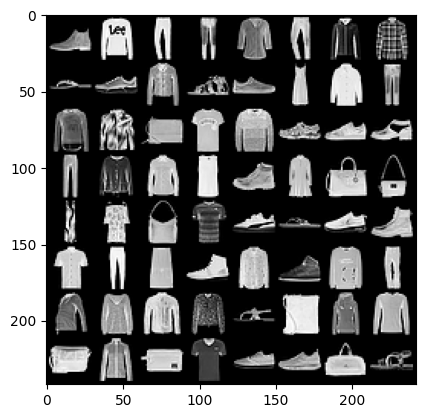

복원된 이미지입니다.


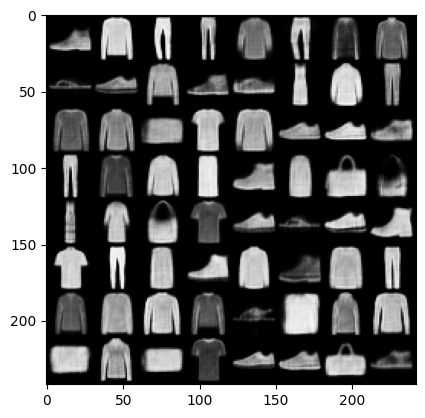

In [43]:
print("데이터 배치의 이미지입니다.")
plt.imshow(utils.make_grid(test_image[:64].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

print("복원된 이미지입니다.")
plt.imshow(utils.make_grid(reconstruction[:64].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

In [52]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(device)
    generated_images = vae.decode(noise)

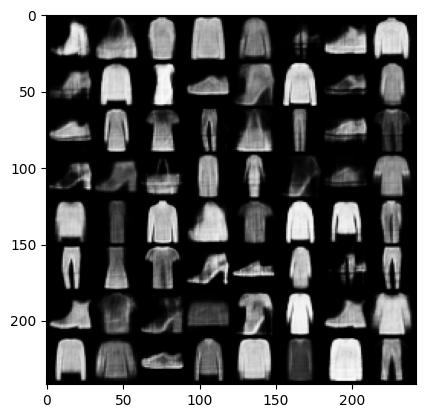

In [53]:
plt.imshow(utils.make_grid(generated_images[:64].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()